In [115]:
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import os
import cv2
import math
import random
import numpy as np
from tqdm import tqdm
from pprint import pprint
from augmentations import *
random.seed(10)

## Initial Investigation

In [2]:
ORI_BASE_DIR = r"F:\Minor Data Collection\Final Image Data\Monument Original\Original Image Dataset"
AUG_BASE_DIR = r"F:\Minor Data Collection\Final Image Data\Monument Original\Augmented Image Dataset (2nd try)"
annotation_path = 'Annotations'
jpg_image_path = 'JPEGImages'
ignore_list = ['kotilingeshvara', 'til mahadev narayan temple', 'king statue']
mistake_list = ['degutale temple', 'kritipur tower', 'degu tale']

In [3]:
def xml_to_df(path):
    xml_list = []
    class_name = ''
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            class_name = member[0].text
            if class_name not in ignore_list:
                if class_name in mistake_list:
                    if class_name == 'degutale temple' or class_name == 'degu tale':
                        class_name = 'degu tale temple_KDS'
                    elif class_name == 'kritipur tower':
                        class_name = 'kirtipur tower'
                value = (root.find('filename').text,
                         int(root.find('size')[0].text),
                         int(root.find('size')[1].text),
                         class_name,
                         int(member[4][0].text),
                         int(member[4][1].text),
                         int(member[4][2].text),
                         int(member[4][3].text)
                         )
                xml_list.append(value)
    column_name = ['class count', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    return pd.DataFrame(xml_list, columns=column_name)

In [4]:
# Analyzes XMLs in an annotation file and gives a bar chart 
def xml_to_bar_chart(path, count_thres = 100, print_plot = None):
    df = xml_to_df(path)
    class_dict = dict(df.groupby(['class']).count()['class count'].items())
    x_label = list()
    y_label = list()
    for key, value in class_dict.items():
        if value < count_thres and key not in ignore_list:
            x_label.append(key)
            y_label.append(value)
            
    plt.figure(figsize = (12, 7), dpi = 90)
    plt.style.use('seaborn-whitegrid')
    plt.bar(x_label, y_label, width = 0.75)
    plt.xticks(rotation = 90)
    plt.yticks(np.arange(0, count_thres, 50))
    font = {'color': 'black', 'size': 16, 'weight': 'bold'}
    plt.xlabel('Monument Classes', fontdict = font)
    plt.ylabel('Classes Counts', fontdict = font)
#     plt.axhline(y = 600, color = 'b', linestyle = '--')
#     plt.axhline(y = 900, color = 'r', linestyle = '--')
    plt.title('Augmented Dataset', fontdict=font)
#     if print_plot is not None:
#         save_loc = os.path.join('Jpgs', print_plot + '.jpg')
#         plt.savefig(save_loc, dpi = 240, bbox_inches = 'tight', pad_inches = 0.2)
    plt.show()

In [5]:
# xml_to_bar_chart(os.path.join(ORI_BASE_DIR, annotation_path), 800)

In [6]:
# Analyzes XMLs in an annotation file and gives 'class name list' & 'class [key:value] pair dictioary'
def lower_class_dict(path, count_thres = 100):
    df = xml_to_df(path)
    _dict = dict(df.groupby(['class']).count()['class count'].items())
    class_list = list()
    class_dict = dict()
    for key, value in _dict.items():
        if value < count_thres:
            class_list.append(key)
            class_dict[key] = value
    return class_list, class_dict 

In [18]:
def validate_class_name(class_name):
    if class_name in mistake_list:
        if class_name == 'degutale temple' or class_name == 'degu tale':
            class_name = 'degu tale temple_KDS'
        elif class_name == 'kritipur tower':
            class_name = 'kirtipur tower'
    return class_name
                    

In [184]:
def find_contained_filenames(mn_class, invalid_classes = None):
    output_list =list()
    
    for xml_file in glob.glob(os.path.join(ORI_BASE_DIR, annotation_path) + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        add_to_list = True
        
        if invalid_classes is not None:
            for member in root.findall('object'):
                class_name = member[0].text
                class_name = validate_class_name(class_name)
                if class_name in invalid_classes:
                    add_to_list = False
                    
        if add_to_list:
            for member in root.findall('object'):
                class_name = member[0].text
                class_name = validate_class_name(class_name)
                if class_name == mn_class:
                    output_list.append(root.find('filename').text.split('.')[0])
                    
    return output_list

In [235]:
def analyze_visualize(mn_class, not_include_list = None, scale = 6):
    # first get files related to that monument class
    examine_filenames = find_contained_filenames(mn_class, invalid_classes = not_include_list)
    
    # analyze the augmented annotations file for initial dictionary 
    df = xml_to_df(os.path.join(AUG_BASE_DIR, annotation_path))
    original_dict = dict(df.groupby(['class']).count()['class count'].items())
    
    output_dict = {}
    ori_dict_copy = original_dict.copy()
    for filename in examine_filenames:
        input_path = os.path.join(ORI_BASE_DIR, annotation_path, filename + '.xml')
        tree = ET.parse(input_path)
        root = tree.getroot()
        for member in root.findall('object'):
            class_name = member[0].text
            class_name = validate_class_name(class_name)
            if class_name not in output_dict:
                output_dict[class_name] = 1
            else:
                output_dict[class_name] += 1
    # increase the initial dictionary by synthetic value raise
    for key, value in output_dict.items():
        if key not in ignore_list:
            ori_dict_copy[key] += value * scale

    # then visualize how the augmentation will change the current augmentation
    plt.figure(figsize = (16, 8), dpi = 120)
    x_axis = np.arange(len(original_dict.keys()))
    plt.bar(x_axis, list(ori_dict_copy.values()), 0.5, label = 'augmented')
    plt.bar(x_axis, list(original_dict.values()), 0.5, label = 'original')

    plt.xticks(x_axis, list(original_dict.keys()), rotation = 90)
    plt.legend(loc = 'best')
    plt.show()

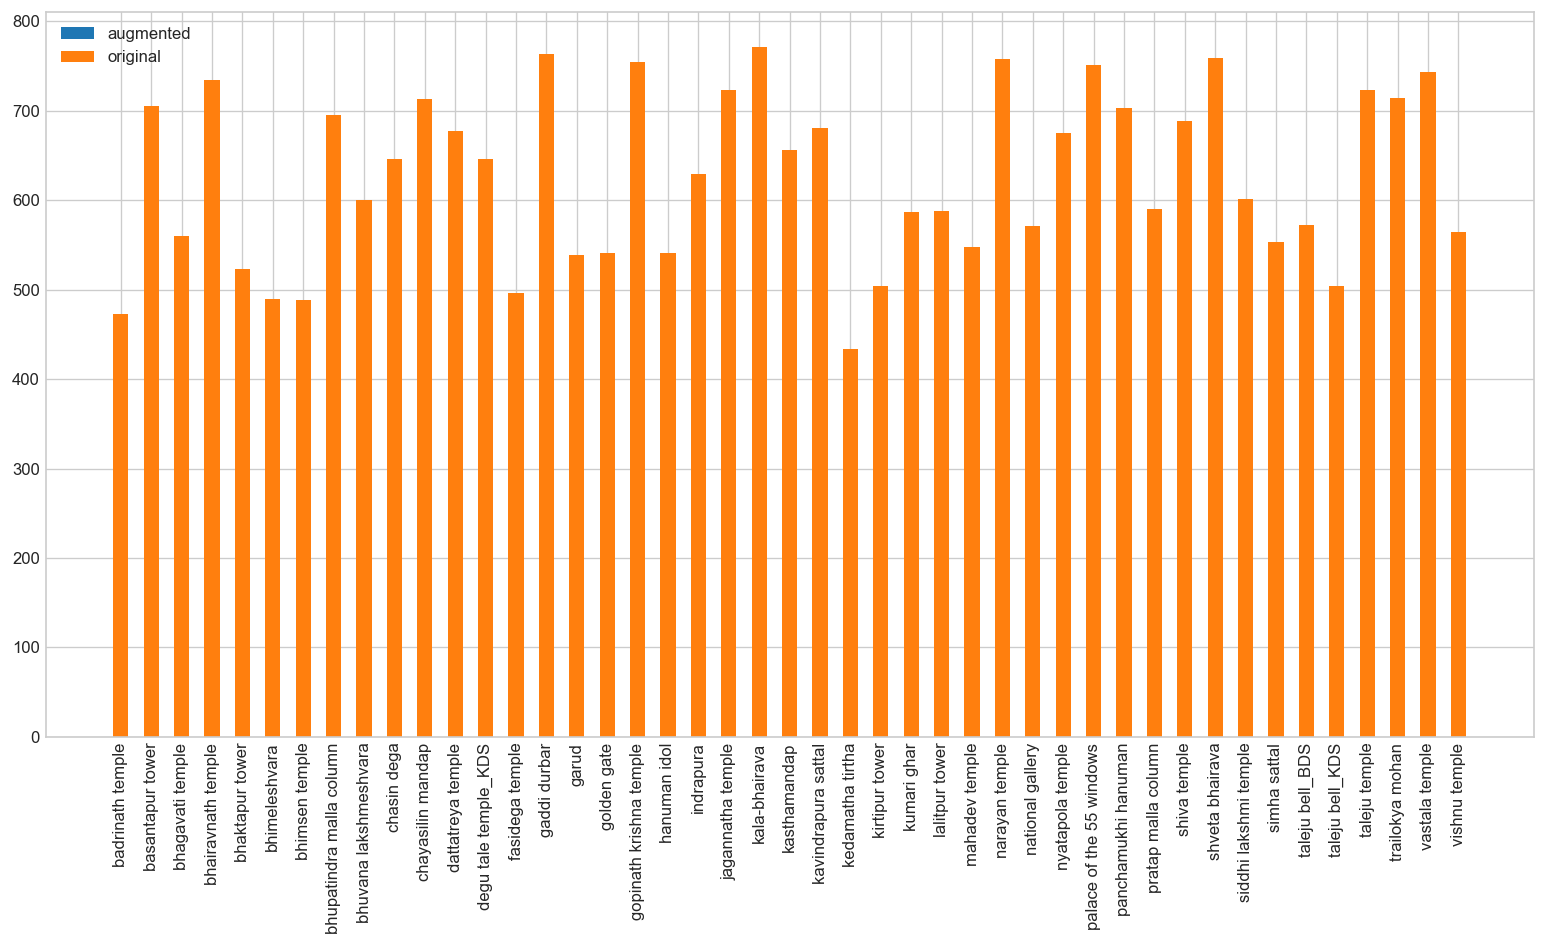

In [401]:
not_include_list = ['shveta bhairava']
analyze_visualize('degu tale temple_KDS', not_include_list, scale = 0)

## Change monument name before doing anything

In [400]:
mn_name = 'degu tale temple_KDS'
mn_short = 'degu_tale_temple_KDS'
all_filenames = find_contained_filenames(mn_name, not_include_list)

count = 2
t_augs_types = 7

outer_count = 0
for filename in tqdm(all_filenames):
    t_index = count % t_augs_types
    if t_index == 0:
        random_rotation(ORI_BASE_DIR, AUG_BASE_DIR, filename, mn_short)
    elif t_index == 1:
        random_brightness_and_contrast(ORI_BASE_DIR, AUG_BASE_DIR, filename, mn_short)
    elif t_index == 2:
        saturation(ORI_BASE_DIR, AUG_BASE_DIR, filename, mn_short)
    elif t_index == 3:
        gaussian_blur(ORI_BASE_DIR, AUG_BASE_DIR, filename, mn_short)
    elif t_index == 4:
        gaussian_noise(ORI_BASE_DIR, AUG_BASE_DIR, filename, mn_short)
    elif t_index == 5:
        saturation(ORI_BASE_DIR, AUG_BASE_DIR, filename, mn_short, True)
    elif t_index == 6: 
        random_translation(ORI_BASE_DIR, AUG_BASE_DIR, filename, mn_short)
    count += 1
#     outer_count += 1
#     if outer_count > 50:
#         break


100%|████████████████████████████████████████████████████████████████████████████████| 152/152 [00:10<00:00, 15.14it/s]


## Data Augmentation

In [67]:
# ORI_ANNOTATION_PATH = os.path.join(ORI_BASE_DIR, annotation_path)
# for monument_class, augmentation_list in analyze_annotations_file(ORI_ANNOTATION_PATH).items():
#     for filename in tqdm(augmentation_list):
#         random_hue_and_saturation(filename, monument_class)
#         random_brightness_and_contrast(filename, monument_class)
#         random_rotation(filename, monument_class)
#         multiple_orient(filename, monument_class)

In [114]:
ORI_ANNOTATION_PATH = os.path.join(ORI_BASE_DIR, annotation_path)
for monument_class, augmentation_list in analyze_annotations_file(os.path.join(ORI_BASE_DIR, 'Merged_Original_Augmented', annotation_path), 610, False).items():
    aug_len = len(augmentation_list)
    count = 0
    for filename in tqdm(augmentation_list):
#         random_hue_and_saturation(filename, monument_class, 3)
#         random_brightness_and_contrast(filename, monument_class, 3)
#         random_rotation(filename, monument_class, 3)
#         random_rotation(filename, monument_class)
#         multiple_orient(filename, monument_class)
        random_translation(filename, monument_class, 0)
        random_translation(filename, monument_class, 2)
#         random_translation(filename, monument_class, 3)
#         random_translation(filename, monument_class, 7)
        count += 2
        if count > 250:
            break


 43%|███████████████████████████████████▎                                              | 28/65 [00:03<00:04,  9.22it/s]

Im here


 52%|██████████████████████████████████████████▉                                       | 34/65 [00:03<00:03,  9.71it/s]

Im here
Im here
Im here


 63%|███████████████████████████████████████████████████▋                              | 41/65 [00:04<00:02,  9.83it/s]

Im here


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:07<00:00,  9.18it/s]


In [107]:
# analyze_annotations_file(os.path.join(ORI_BASE_DIR, 'Merged', annotation_path), 400, True)

In [ ]:
def analyze_annotations_file(path, count_thres = 70, plot = False):
    ls, dt = lower_class_dict(path, count_thres)
    overall_dict = {}
    for monument_class in ls:
        xml_list = []
        filenames_list = []
        class_name = ''
        for xml_file in glob.glob(os.path.join(ORI_BASE_DIR, annotation_path) + '/*.xml'):
            contained_file = False
            tree = ET.parse(xml_file)
            root = tree.getroot()
            for member in root.findall('object'):
                class_name = member[0].text
                if class_name == monument_class:
                    contained_file = True
            if contained_file:
                filenames_list.append(xml_file.split('.')[0].split('\\')[-1])
                for member in root.findall('object'):
                    class_name = member[0].text
                    if class_name not in ignore_list:
                        if class_name in mistake_list:
                            if class_name == 'degutale temple' or class_name == 'degu tale':
                                class_name = 'degu tale temple_KDS'
                            elif class_name == 'kritipur tower':
                                class_name = 'kirtipur tower'
                        value = (root.find('filename').text,
                                 int(root.find('size')[0].text),
                                 int(root.find('size')[1].text),
                                 class_name,
                                 int(member[4][0].text),
                                 int(member[4][1].text),
                                 int(member[4][2].text),
                                 int(member[4][3].text)
                                 )
                        xml_list.append(value)
        column_name = ['class count', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
        df = pd.DataFrame(xml_list, columns=column_name)
        class_dict = dict(df.groupby(['class']).count()['class count'].items())
        x_label = list()
        y_label = list()
        for key, value in class_dict.items():
            x_label.append(key)
            y_label.append(value)
        if plot:
            plt.figure(figsize = (6, 3), dpi = 90)
            plt.bar(x_label, y_label, width = 0.9)
            plt.xticks(rotation = 90)
            plt.title(monument_class)
            plt.show()
        overall_dict[monument_class] = filenames_list
    return overall_dict